# k-NN, Decision Tree, Random Forest, SVM, Neural Network + Bagging, Boosting, CV, Grid Search

##### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVR
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
import warnings # to silence convergence warnings
# Cross validation, bagging, boosting and oob for optimization
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, 
                             BaggingRegressor, GradientBoostingRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as WeightedKNNRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

##### Functions from the exercises

In [2]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    '''
    Function for normalizing the columns (variables) of a data matrix to unit length.
    Returns the normalized data and the L2 norm of the variables 
    
    Input  (X) --------> The data matrix to be normalized 
    Output (X_pre)-----> The normalized data matrix 
    Output (d) --------> Array with the L2 norms of the variables 
    '''
    d = np.linalg.norm(X,axis=0,ord=2)  # d is the euclidian lenghts of the variables 
    d[d==0]=1                           # Avoid dividing by zero if column L2 norm is zero 
    X_pre = X / d                       # Normalize the data with the euclidian lengths
    return X_pre,d                      # Return normalized data and the euclidian lengths

def weighted_knn(K, X, n):
    yhat = np.zeros(n)
    distances = np.zeros(n)
    # For each obs, compare distance to all other points in X
    for i in range(n):
        for j in range(n):
            distances[j] = distance.euclidean(X[i,:], X[j, :])

        # Sort all the distances
        idx = np.argsort(distances)[1:(K + 1)] # Skip first, as distance to "itself" does not make sense
        Wt = sum(distances[idx]) # Weight of k nearest neighbors
        W = distances[idx] / Wt # Weighing average


        yhat[i] = np.matmul(W.T, y[idx]) # Final value is weighted combination of neighbours
    
    return yhat



In [3]:
from sklearn.base import BaseEstimator, RegressorMixin

class WeightedKNNRegressor(BaseEstimator, RegressorMixin):
	def __init__(self, K):
		self.K = K

	def fit(self, X, y):
		self.X = X
		self.y = y

	def predict(self, X):
		n = X.shape[0]
		yhat = np.zeros(n)
		for i in range(n):
			distances = np.array([distance.euclidean(X[i], x) for x in self.X])
			idx = np.argsort(distances)[:self.K]
			Wt = sum(distances[idx])
			W = distances[idx] / Wt
			yhat[i] = np.dot(W, self.y[idx])
		return yhat

##### Load and format data

In [4]:
data = pd.read_csv('./Data/case1Data.csv')
y = np.array(data['y'])
X = np.array(data.drop('y', axis=1))
data = pd.read_csv('./Data/case1Data_Xnew.csv')
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())
X_new = np.array(data)

In [5]:
def fit_transform_data(X):
    # Round the last 5 columns to integers
    X[:, -5:] = np.round(X[:, -5:])

    # Convert to integers, then to strings to force categorical treatment
    cat_data = X[:, -5:].astype(int).astype(str)
    cat_df = pd.DataFrame(cat_data)
    cat = pd.get_dummies(cat_df).values

    # Separate numerical columns
    num = X[:, :-5]
    # Standardize numerical columns
    num, mu = centerData(num)
    num, d = normalize(num)   

    # Concatenate numerical and one-hot encoded categorical columns
    X = np.concatenate((num, cat), axis=1)

    return X, mu, d

def transform_data(X, mu, d):
    # Round the last 5 columns to integers
    X[:, -5:] = np.round(X[:, -5:])

    # Convert to integers, then to strings to force categorical treatment
    cat_data = X[:, -5:].astype(int).astype(str)
    cat_df = pd.DataFrame(cat_data)
    cat = pd.get_dummies(cat_df).values

    # Separate numerical columns
    num = X[:, :-5]
    # Standardize numerical columns using the mean and std from the training set
    num = (num - mu) / d

    # Concatenate numerical and one-hot encoded categorical columns
    X = np.concatenate((num, cat), axis=1)

    return X

In [6]:
# pca = PCA(n_components=0.9)
# pca_plot = PCA(n_components=2)
# X_pca = pca.fit_transform(X)
# X_pca_plot = pca_plot.fit_transform(X)

# X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y, test_size=0.2, random_state=1312)

##### Analyses

In [7]:
# # Plot pca

# plt.scatter(X_pca_plot[:,0], X_pca_plot[:,1], c=y, cmap='viridis')
# plt.colorbar()
# plt.show()

#### Model selection

In [8]:
# Model defitinions
rf = RandomForestRegressor(random_state=1312)
dt = DecisionTreeRegressor(random_state=1312)
svr = SVR()
ada = AdaBoostRegressor(random_state=1312)
bag = BaggingRegressor(random_state=1312)
dt = DecisionTreeRegressor(random_state=1312)
knn = WeightedKNNRegressor(5)
ols = LinearRegression() 
rr = Ridge() 
lasso = Lasso()
elnet = ElasticNet()




=== PERMUTATION 1/5 ===

--- VANILLA MODELS ---

Evaluating RandomForest...
RandomForest - Best params: {'n_estimators': 200, 'max_depth': None}
RandomForest - Best CV RMSE: 50.6560

Evaluating DecisionTree...
DecisionTree - Best params: {'max_depth': None}
DecisionTree - Best CV RMSE: 64.4661

Evaluating SVR...
SVR - Best params: {'C': 10, 'gamma': 'auto'}
SVR - Best CV RMSE: 72.4940

Evaluating KNN...
KNN - Best params: {'n_neighbors': 20}
KNN - Best CV RMSE: 73.8020

Evaluating AdaBoost...
AdaBoost - Best params: {'n_estimators': 200}
AdaBoost - Best CV RMSE: 50.2190

Evaluating Bagging...
Bagging - Best params: {'n_estimators': 500}
Bagging - Best CV RMSE: 50.5927

Evaluating OLS...
OLS - No params to tune - CV RMSE: 57.0995

Evaluating Ridge...
Ridge - Best params: {'alpha': np.float64(0.042169650342858224)}
Ridge - Best CV RMSE: 53.4168

Evaluating Lasso...
Lasso - Best params: {'alpha': np.float64(0.3679505646173878)}
Lasso - Best CV RMSE: 41.0371


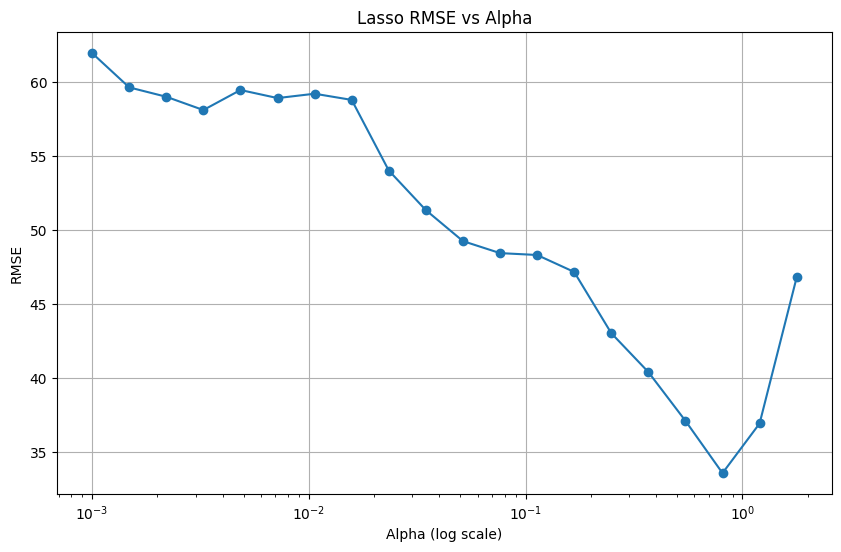


Evaluating ElasticNet...
ElasticNet - Best params: {'alpha': np.float64(0.006493816315762113), 'l1_ratio': 0.9}
ElasticNet - Best CV RMSE: 52.6008

=== PERMUTATION 2/5 ===

--- VANILLA MODELS ---

Evaluating RandomForest...
RandomForest - Best params: {'n_estimators': 200, 'max_depth': 10}
RandomForest - Best CV RMSE: 50.2549

Evaluating DecisionTree...
DecisionTree - Best params: {'max_depth': 10}
DecisionTree - Best CV RMSE: 68.1504

Evaluating SVR...
SVR - Best params: {'C': 10, 'gamma': 'scale'}
SVR - Best CV RMSE: 72.3819

Evaluating KNN...
KNN - Best params: {'n_neighbors': 20}
KNN - Best CV RMSE: 70.1116

Evaluating AdaBoost...
AdaBoost - Best params: {'n_estimators': 50}
AdaBoost - Best CV RMSE: 50.2076

Evaluating Bagging...
Bagging - Best params: {'n_estimators': 200}
Bagging - Best CV RMSE: 50.3376

Evaluating OLS...
OLS - No params to tune - CV RMSE: 50.8975

Evaluating Ridge...
Ridge - Best params: {'alpha': np.float64(0.042169650342858224)}
Ridge - Best CV RMSE: 47.0107


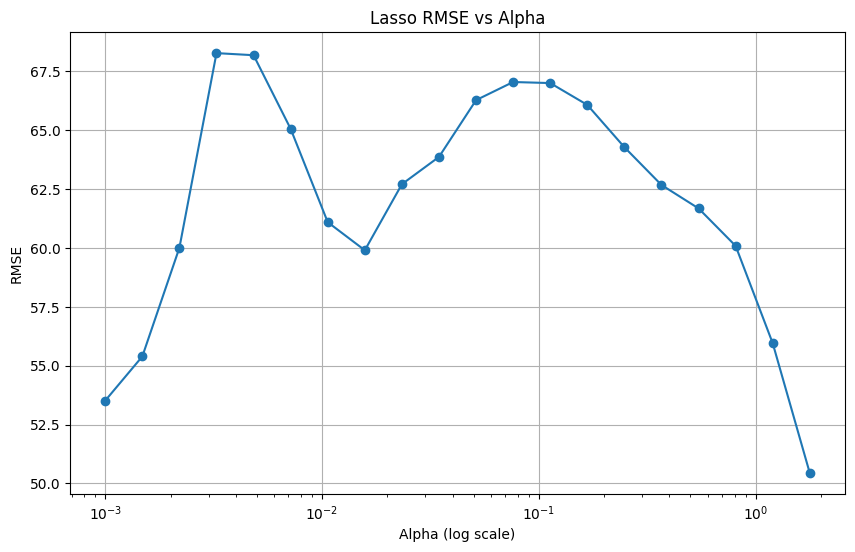


Evaluating ElasticNet...
ElasticNet - Best params: {'alpha': np.float64(0.006493816315762113), 'l1_ratio': 0.9}
ElasticNet - Best CV RMSE: 45.9993

=== PERMUTATION 3/5 ===

--- VANILLA MODELS ---

Evaluating RandomForest...
RandomForest - Best params: {'n_estimators': 200, 'max_depth': 10}
RandomForest - Best CV RMSE: 50.9328

Evaluating DecisionTree...
DecisionTree - Best params: {'max_depth': None}
DecisionTree - Best CV RMSE: 66.7849

Evaluating SVR...
SVR - Best params: {'C': 10, 'gamma': 'auto'}
SVR - Best CV RMSE: 72.2493

Evaluating KNN...
KNN - Best params: {'n_neighbors': 20}
KNN - Best CV RMSE: 73.6476

Evaluating AdaBoost...
AdaBoost - Best params: {'n_estimators': 500}
AdaBoost - Best CV RMSE: 52.9640

Evaluating Bagging...
Bagging - Best params: {'n_estimators': 200}
Bagging - Best CV RMSE: 51.0163

Evaluating OLS...
OLS - No params to tune - CV RMSE: 54.7579

Evaluating Ridge...
Ridge - Best params: {'alpha': np.float64(0.042169650342858224)}
Ridge - Best CV RMSE: 52.857

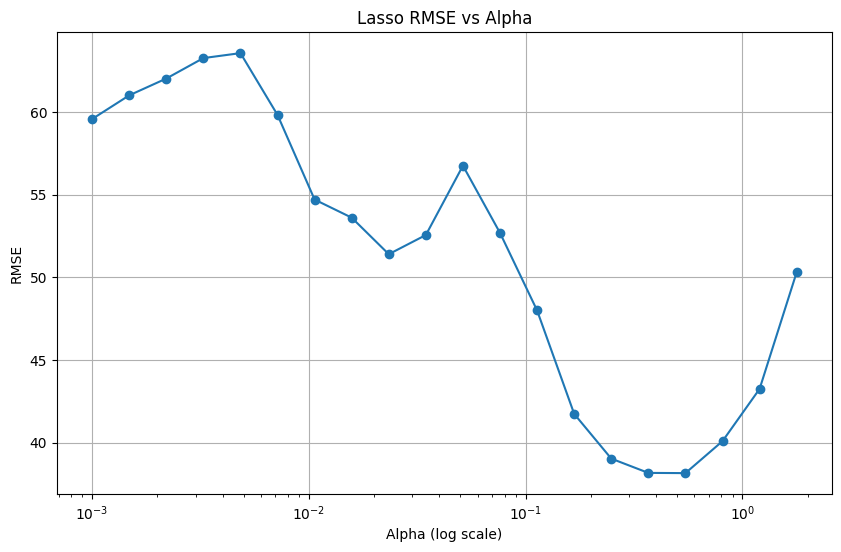


Evaluating ElasticNet...
ElasticNet - Best params: {'alpha': np.float64(0.006493816315762113), 'l1_ratio': 0.9}
ElasticNet - Best CV RMSE: 52.1520

=== PERMUTATION 4/5 ===

--- VANILLA MODELS ---

Evaluating RandomForest...
RandomForest - Best params: {'n_estimators': 50, 'max_depth': None}
RandomForest - Best CV RMSE: 47.4916

Evaluating DecisionTree...
DecisionTree - Best params: {'max_depth': 10}
DecisionTree - Best CV RMSE: 67.8238

Evaluating SVR...
SVR - Best params: {'C': 10, 'gamma': 'scale'}
SVR - Best CV RMSE: 70.4832

Evaluating KNN...
KNN - Best params: {'n_neighbors': 20}
KNN - Best CV RMSE: 70.2113

Evaluating AdaBoost...
AdaBoost - Best params: {'n_estimators': 500}
AdaBoost - Best CV RMSE: 46.9747

Evaluating Bagging...
Bagging - Best params: {'n_estimators': 500}
Bagging - Best CV RMSE: 47.5714

Evaluating OLS...
OLS - No params to tune - CV RMSE: 50.8695

Evaluating Ridge...
Ridge - Best params: {'alpha': np.float64(0.042169650342858224)}
Ridge - Best CV RMSE: 48.843

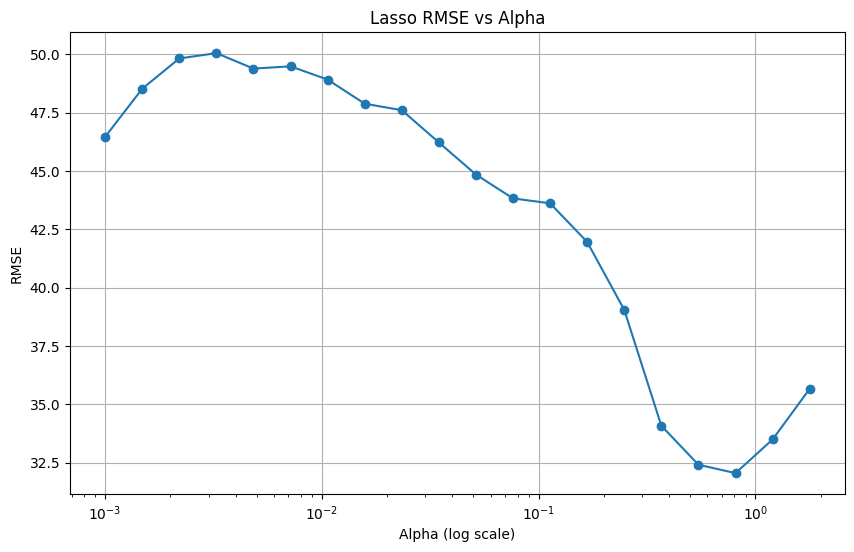


Evaluating ElasticNet...
ElasticNet - Best params: {'alpha': np.float64(0.006493816315762113), 'l1_ratio': 0.9}
ElasticNet - Best CV RMSE: 48.1772

=== PERMUTATION 5/5 ===

--- VANILLA MODELS ---

Evaluating RandomForest...
RandomForest - Best params: {'n_estimators': 200, 'max_depth': None}
RandomForest - Best CV RMSE: 49.8812

Evaluating DecisionTree...
DecisionTree - Best params: {'max_depth': 10}
DecisionTree - Best CV RMSE: 71.7391

Evaluating SVR...
SVR - Best params: {'C': 1, 'gamma': 'auto'}
SVR - Best CV RMSE: 73.5284

Evaluating KNN...
KNN - Best params: {'n_neighbors': 20}
KNN - Best CV RMSE: 75.8441

Evaluating AdaBoost...
AdaBoost - Best params: {'n_estimators': 500}
AdaBoost - Best CV RMSE: 50.1703

Evaluating Bagging...
Bagging - Best params: {'n_estimators': 200}
Bagging - Best CV RMSE: 49.5027

Evaluating OLS...
OLS - No params to tune - CV RMSE: 46.8280

Evaluating Ridge...
Ridge - Best params: {'alpha': np.float64(0.042169650342858224)}
Ridge - Best CV RMSE: 44.2165

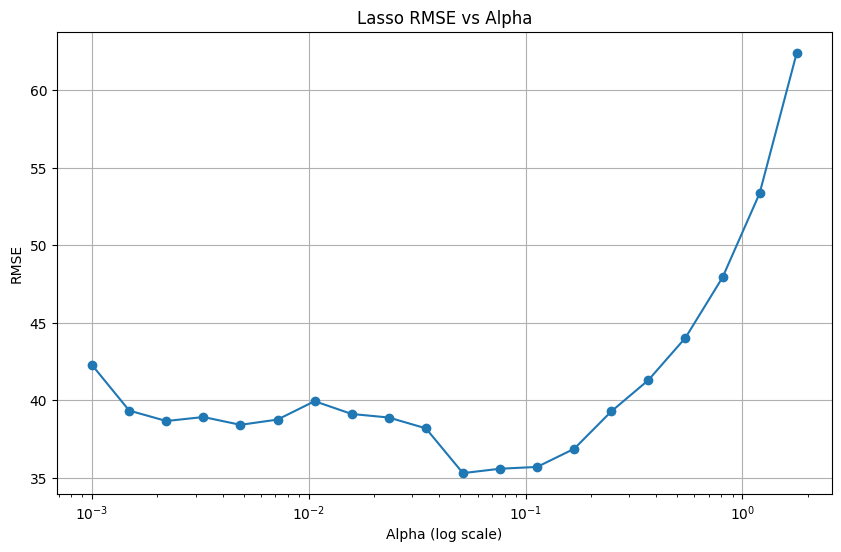


Evaluating ElasticNet...
ElasticNet - Best params: {'alpha': np.float64(0.006493816315762113), 'l1_ratio': 0.9}
ElasticNet - Best CV RMSE: 43.4460

=== BOOSTED MODELS ===

Evaluating AdaBoost_DecisionTree...
AdaBoost_DecisionTree - Best CV RMSE: 49.3377

Evaluating GradientBoosting...
GradientBoosting - Best CV RMSE: 45.1712

Evaluating AdaBoost_OLS...
AdaBoost_OLS - Best CV RMSE: 53.9329

Evaluating AdaBoost_Ridge...
AdaBoost_Ridge - Best CV RMSE: 53.9340

Evaluating AdaBoost_Lasso...
AdaBoost_Lasso - Best CV RMSE: 40.1055

=== BAGGED MODELS ===

Evaluating Bagging_RandomForest...
Bagging_RandomForest - Best CV RMSE: 51.4180

Evaluating Bagging_DecisionTree...
Bagging_DecisionTree - Best CV RMSE: 51.9493

Evaluating Bagging_KNN...
Bagging_KNN - Best CV RMSE: 70.0754

Evaluating Bagging_OLS...
Bagging_OLS - Best CV RMSE: 53.3748

Evaluating Bagging_Ridge...
Bagging_Ridge - Best CV RMSE: 54.2198

Evaluating Bagging_Lasso...
Bagging_Lasso - Best CV RMSE: 39.5771

=== FINAL MODEL EVALUAT

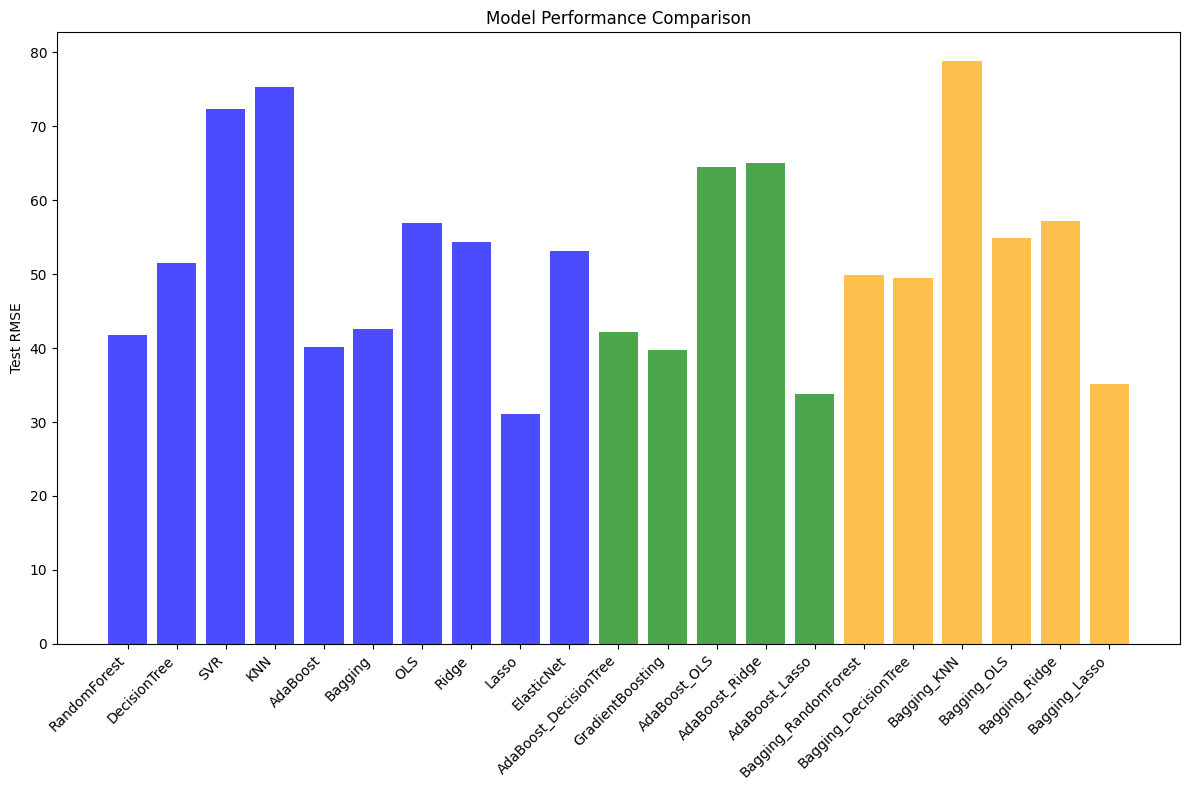

In [9]:
# Custom cross-validation, bagging, boosting and oob for optimization
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, 
                             BaggingRegressor, GradientBoostingRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as WeightedKNNRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
from itertools import product
import copy

warnings.filterwarnings("ignore", category=UserWarning)

X_dev, X_final_test, y_dev, y_final_test = train_test_split(X, y, test_size=0.2, random_state=1312)

columns = []

# Define the models and their parameter grids
models = {
    'RandomForest': (RandomForestRegressor(random_state=1312), 
                   {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
    'DecisionTree': (DecisionTreeRegressor(random_state=1312), 
                   {'max_depth': [None, 10, 20, 30]}),
    'SVR': (SVR(), 
          {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}), 
    'KNN': (WeightedKNNRegressor(), 
          {'n_neighbors': [5, 10, 20]}), 
    'AdaBoost': (AdaBoostRegressor(random_state=1312), 
               {'n_estimators': [10, 50, 100, 200, 500]}), 
    'Bagging': (BaggingRegressor(random_state=1312), 
              {'n_estimators': [10, 50, 100, 200, 500]}),
    'OLS': (LinearRegression(), {}),
    'Ridge': (Ridge(random_state=1312), 
            {'alpha': np.logspace(-3, 0.25, num=5)}),
    'Lasso': (Lasso(random_state=1312), 
            {'alpha': np.logspace(-3, 0.25, num=20)}),
    'ElasticNet': (ElasticNet(random_state=1312), 
                 {'alpha': np.logspace(-3, 0.25, num=5), 
                  'l1_ratio': [0.1, 0.5, 0.7, 0.9]})
}

# Number of permutations to run
n_permutations = 5
# Number of CV folds
n_splits = 5

# Results storage
all_results = {
    'vanilla': {},
    'bagged': {},
    'boosted': {}
}

# Best model tracking
best_estimators = {}
best_params = {}
best_cv_scores = {}

# OUTER LOOP - handles permutation and data preprocessing
for perm_idx in range(n_permutations):
    print(f"\n=== PERMUTATION {perm_idx+1}/{n_permutations} ===")
    
    # 1. Permute the data
    random_state = 1312 + perm_idx
    indices = np.random.RandomState(random_state).permutation(len(X_dev))
    X_permuted, y_permuted = X_dev[indices], y_dev[indices]
    
    # 2. Set up cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # VANILLA MODELS
    print("\n--- VANILLA MODELS ---")
    for model_name, (base_model, param_grid) in models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Initialize tracking for this model
        if model_name not in best_cv_scores:
            best_cv_scores[model_name] = float('inf')
            best_params[model_name] = {}
            all_results['vanilla'][model_name] = []
        
        # If no parameters to tune, just do simple CV
        if not param_grid:
            fold_scores = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_permuted)):
                # Get fold data
                X_fold_train, X_fold_val = X_permuted[train_idx], X_permuted[val_idx]
                y_fold_train, y_fold_val = y_permuted[train_idx], y_permuted[val_idx]
                
                # 3. Fill NA values in this fold
                # Convert to DataFrame for easier handling of NaN values
                X_fold_train_df = pd.DataFrame(X_fold_train)
                X_fold_val_df = pd.DataFrame(X_fold_val)
                
                # Fill NaN values with mean of training data
                for col in X_fold_train_df.columns:
                    fill_value = X_fold_train_df[col].mean()
                    X_fold_train_df[col] = X_fold_train_df[col].fillna(fill_value)
                    X_fold_val_df[col] = X_fold_val_df[col].fillna(fill_value)
                
                # 4. Standardize the data using training fold stats
                X_fold_train_scaled, mu, d = fit_transform_data(X_fold_train_df.values)
                X_fold_val_scaled = transform_data(X_fold_val_df.values, mu, d)
                
                # Ensure both train and val sets have the same columns after one-hot encoding
                X_fold_train_scaled = pd.DataFrame(X_fold_train_scaled)
                X_fold_val_scaled = pd.DataFrame(X_fold_val_scaled)
                X_fold_val_scaled = X_fold_val_scaled.reindex(columns=X_fold_train_scaled.columns, fill_value=0)

                # Train and evaluate model
                model = copy.deepcopy(base_model)
                model.fit(X_fold_train_scaled, y_fold_train)
                y_pred = model.predict(X_fold_val_scaled)
                mse = mean_squared_error(y_fold_val, y_pred)
                rmse = np.sqrt(mse)
                fold_scores.append(rmse)
                
            # Average the fold scores
            avg_rmse = np.mean(fold_scores)
            all_results['vanilla'][model_name].append(avg_rmse)
            
            print(f"{model_name} - No params to tune - CV RMSE: {avg_rmse:.4f}")
            
            # Check if this is the best score so far
            if avg_rmse < best_cv_scores[model_name]:
                best_cv_scores[model_name] = avg_rmse
                # Train on all dev data for final evaluation
                X_dev_df = pd.DataFrame(X_dev)
                for col in X_dev_df.columns:
                    X_dev_df[col] = X_dev_df[col].fillna(X_dev_df[col].mean())
                
                X_dev_scaled, mu, d = fit_transform_data(X_dev_df.values)
                
                scaler = [mu, d]

                best_model = copy.deepcopy(base_model)
                best_model.fit(X_dev_scaled, y_dev)
                best_estimators[model_name] = (best_model, scaler)
        
        else:
            # INNER LOOP - hyperparameter tuning
            # Generate all parameter combinations
            param_keys = list(param_grid.keys())
            param_values = list(param_grid.values())
            param_combinations = list(product(*param_values))
            
            best_avg_rmse = float('inf')
            best_param_combo = None
            
            for param_idx, param_combo in enumerate(param_combinations):
                param_dict = {key: value for key, value in zip(param_keys, param_combo)}
                
                fold_scores = []
                for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_permuted)):
                    # Get fold data
                    X_fold_train, X_fold_val = X_permuted[train_idx], X_permuted[val_idx]
                    y_fold_train, y_fold_val = y_permuted[train_idx], y_permuted[val_idx]
                    
                    # 3. Fill NA values
                    X_fold_train_df = pd.DataFrame(X_fold_train)
                    X_fold_val_df = pd.DataFrame(X_fold_val)
                    
                    for col in X_fold_train_df.columns:
                        fill_value = X_fold_train_df[col].mean()
                        X_fold_train_df[col] = X_fold_train_df[col].fillna(fill_value)
                        X_fold_val_df[col] = X_fold_val_df[col].fillna(fill_value)
                    
                    # 4. Standardize
                    X_fold_train_scaled, mu, d = fit_transform_data(X_fold_train_df.values)
                    X_fold_val_scaled = transform_data(X_fold_val_df.values, mu, d)

                    # Ensure both train and val sets have the same columns after one-hot encoding
                    X_fold_train_scaled = pd.DataFrame(X_fold_train_scaled)
                    X_fold_val_scaled = pd.DataFrame(X_fold_val_scaled)
                    X_fold_val_scaled = X_fold_val_scaled.reindex(columns=X_fold_train_scaled.columns, fill_value=0)

                    # Create model with current parameters
                    model = copy.deepcopy(base_model)
                    model.set_params(**param_dict)
                    
                    # Train and evaluate
                    model.fit(X_fold_train_scaled, y_fold_train)
                    y_pred = model.predict(X_fold_val_scaled)
                    mse = mean_squared_error(y_fold_val, y_pred)
                    rmse = np.sqrt(mse)
                    fold_scores.append(rmse)
                
                # Average the fold scores for this parameter combination
                avg_rmse = np.mean(fold_scores)
                
                # Check if this is the best parameter combination
                if avg_rmse < best_avg_rmse:
                    best_avg_rmse = avg_rmse
                    best_param_combo = param_dict
            
            # Record results for this permutation
            all_results['vanilla'][model_name].append(best_avg_rmse)
            
            print(f"{model_name} - Best params: {best_param_combo}")
            print(f"{model_name} - Best CV RMSE: {best_avg_rmse:.4f}")
            
            # Check if this is the best score across all permutations
            if best_avg_rmse < best_cv_scores[model_name]:
                best_cv_scores[model_name] = best_avg_rmse
                best_params[model_name] = best_param_combo
                
                # Train on all dev data with best parameters
                X_dev_df = pd.DataFrame(X_dev)
                for col in X_dev_df.columns:
                    X_dev_df[col] = X_dev_df[col].fillna(X_dev_df[col].mean())
                
                X_dev_scaled, mu, d = fit_transform_data(X_dev_df.values)
                scaler = [mu, d]
                
                best_model = copy.deepcopy(base_model)
                best_model.set_params(**best_param_combo)
                best_model.fit(X_dev_scaled, y_dev)
                best_estimators[model_name] = (best_model, scaler)
            
            if model_name == 'Lasso':
                # Track alpha values and corresponding RMSE scores
                alpha_values = []
                rmse_values = []
                
                # For each parameter combination (in this case, different alpha values)
                for param_idx, param_combo in enumerate(param_combinations):
                    param_dict = {key: value for key, value in zip(param_keys, param_combo)}
                    alpha = param_dict['alpha']
                    alpha_values.append(alpha)
                    
                    fold_scores = []
                    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_permuted)):
                        # [Keep your existing fold processing code]
                        
                        # Create model with current alpha
                        model = copy.deepcopy(base_model)
                        model.set_params(**param_dict)
                        
                        # Train and evaluate
                        model.fit(X_fold_train_scaled, y_fold_train)
                        y_pred = model.predict(X_fold_val_scaled)
                        mse = mean_squared_error(y_fold_val, y_pred)
                        rmse = np.sqrt(mse)
                        fold_scores.append(rmse)
                    
                    # Average the fold scores for this alpha
                    avg_rmse = np.mean(fold_scores)
                    rmse_values.append(avg_rmse)
                    
                    # [Continue with your existing code]
                
                # After testing all alphas, plot the results
                plt.figure(figsize=(10, 6))
                plt.semilogx(alpha_values, rmse_values, marker='o')
                plt.xlabel('Alpha (log scale)')
                plt.ylabel('RMSE')
                plt.title(f'Lasso RMSE vs Alpha')
                plt.grid(True)
                plt.show()

# After all permutations, evaluate BOOSTED models
print("\n=== BOOSTED MODELS ===")
boosted_models = {
    'AdaBoost_DecisionTree': (AdaBoostRegressor(
        estimator=best_estimators['DecisionTree'][0], n_estimators=100, random_state=1312), {}),
    'GradientBoosting': (GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1312), {}),
    'AdaBoost_OLS': (AdaBoostRegressor(
        estimator=best_estimators['OLS'][0], n_estimators=100, random_state=1312), {}),
    'AdaBoost_Ridge': (AdaBoostRegressor(
        estimator=best_estimators['Ridge'][0], n_estimators=100, random_state=1312), {}),
    'AdaBoost_Lasso': (AdaBoostRegressor(
        estimator=best_estimators['Lasso'][0], n_estimators=100, random_state=1312), {})
}

# Run similar CV process for boosted models
for model_name, (base_model, _) in boosted_models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Initialize tracking
    best_cv_scores[model_name] = float('inf')
    all_results['boosted'][model_name] = []
    
    # Run through permutations
    for perm_idx in range(n_permutations):
        random_state = 1312 + perm_idx
        indices = np.random.RandomState(random_state).permutation(len(X_dev))
        X_permuted, y_permuted = X_dev[indices], y_dev[indices]
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        fold_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_permuted)):
            # Get fold data
            X_fold_train, X_fold_val = X_permuted[train_idx], X_permuted[val_idx]
            y_fold_train, y_fold_val = y_permuted[train_idx], y_permuted[val_idx]
            
            # Preprocess
            X_fold_train_df = pd.DataFrame(X_fold_train)
            X_fold_val_df = pd.DataFrame(X_fold_val)
            
            for col in X_fold_train_df.columns:
                fill_value = X_fold_train_df[col].mean()
                X_fold_train_df[col] = X_fold_train_df[col].fillna(fill_value)
                X_fold_val_df[col] = X_fold_val_df[col].fillna(fill_value)
            
            X_fold_train_scaled, mu, d = fit_transform_data(X_fold_train_df.values)
            X_fold_val_scaled = transform_data(X_fold_val_df.values, mu, d)

            # Make sure both train and val sets have the same columns after one-hot encoding
            X_fold_train_scaled = pd.DataFrame(X_fold_train_scaled)
            X_fold_val_scaled = pd.DataFrame(X_fold_val_scaled)
            X_fold_val_scaled = X_fold_val_scaled.reindex(columns=X_fold_train_scaled.columns, fill_value=0)
            
            # Train and evaluate
            model = copy.deepcopy(base_model)
            model.fit(X_fold_train_scaled, y_fold_train)
            y_pred = model.predict(X_fold_val_scaled)
            mse = mean_squared_error(y_fold_val, y_pred)
            rmse = np.sqrt(mse)
            fold_scores.append(rmse)
        
        # Average the fold scores
        avg_rmse = np.mean(fold_scores)
        all_results['boosted'][model_name].append(avg_rmse)
        
        # Check if this is the best score
        if avg_rmse < best_cv_scores[model_name]:
            best_cv_scores[model_name] = avg_rmse
            
            # Train on all dev data
            X_dev_df = pd.DataFrame(X_dev)
            for col in X_dev_df.columns:
                X_dev_df[col] = X_dev_df[col].fillna(X_dev_df[col].mean())
            
            X_dev_scaled, mu, d = fit_transform_data(X_dev_df.values)
            scaler = [mu, d]

            best_model = copy.deepcopy(base_model)
            best_model.fit(X_dev_scaled, y_dev)
            best_estimators[model_name] = (best_model, scaler)
    
    print(f"{model_name} - Best CV RMSE: {best_cv_scores[model_name]:.4f}")

# BAGGED models
print("\n=== BAGGED MODELS ===")
bagging_models = {
    'Bagging_RandomForest': (BaggingRegressor(
        estimator=best_estimators['RandomForest'][0], n_estimators=10, random_state=1312), {}),
    'Bagging_DecisionTree': (BaggingRegressor(
        estimator=best_estimators['DecisionTree'][0], n_estimators=10, random_state=1312), {}),
    'Bagging_KNN': (BaggingRegressor(
        estimator=best_estimators['KNN'][0], n_estimators=10, random_state=1312), {}),
    'Bagging_OLS': (BaggingRegressor(
        estimator=best_estimators['OLS'][0], n_estimators=10, random_state=1312), {}),
    'Bagging_Ridge': (BaggingRegressor(
        estimator=best_estimators['Ridge'][0], n_estimators=10, random_state=1312), {}),
    'Bagging_Lasso': (BaggingRegressor(
        estimator=best_estimators['Lasso'][0], n_estimators=10, random_state=1312), {})
}

# Run similar CV process for bagged models
for model_name, (base_model, _) in bagging_models.items():
    print(f"\nEvaluating {model_name}...")
    
    # Initialize tracking
    best_cv_scores[model_name] = float('inf')
    all_results['bagged'][model_name] = []
    
    # Run through permutations
    for perm_idx in range(n_permutations):
        random_state = 1312 + perm_idx
        indices = np.random.RandomState(random_state).permutation(len(X_dev))
        X_permuted, y_permuted = X_dev[indices], y_dev[indices]
        
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        fold_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_permuted)):
            # Get fold data
            X_fold_train, X_fold_val = X_permuted[train_idx], X_permuted[val_idx]
            y_fold_train, y_fold_val = y_permuted[train_idx], y_permuted[val_idx]
            
            # Preprocess
            X_fold_train_df = pd.DataFrame(X_fold_train)
            X_fold_val_df = pd.DataFrame(X_fold_val)
            
            for col in X_fold_train_df.columns:
                fill_value = X_fold_train_df[col].mean()
                X_fold_train_df[col] = X_fold_train_df[col].fillna(fill_value)
                X_fold_val_df[col] = X_fold_val_df[col].fillna(fill_value)
            
            X_fold_train_scaled, mu, d = fit_transform_data(X_fold_train_df.values)
            X_fold_val_scaled = transform_data(X_fold_val_df.values, mu, d)

            # Ensure both train and val sets have the same columns after one-hot encoding
            X_fold_train_scaled = pd.DataFrame(X_fold_train_scaled)
            X_fold_val_scaled = pd.DataFrame(X_fold_val_scaled)
            X_fold_val_scaled = X_fold_val_scaled.reindex(columns=X_fold_train_scaled.columns, fill_value=0)
            columns = X_fold_train_scaled.columns.tolist()
            
            # Train and evaluate
            model = copy.deepcopy(base_model)
            model.fit(X_fold_train_scaled, y_fold_train)
            y_pred = model.predict(X_fold_val_scaled)
            mse = mean_squared_error(y_fold_val, y_pred)
            rmse = np.sqrt(mse)
            fold_scores.append(rmse)
        
        # Average the fold scores
        avg_rmse = np.mean(fold_scores)
        all_results['bagged'][model_name].append(avg_rmse)
        
        # Check if this is the best score
        if avg_rmse < best_cv_scores[model_name]:
            best_cv_scores[model_name] = avg_rmse
            
            # Train on all dev data
            X_dev_df = pd.DataFrame(X_dev)
            for col in X_dev_df.columns:
                X_dev_df[col] = X_dev_df[col].fillna(X_dev_df[col].mean())
            
            X_dev_scaled, mu, d = fit_transform_data(X_dev_df.values)
            scaler = [mu, d]
            
            best_model = copy.deepcopy(base_model)
            best_model.fit(X_dev_scaled, y_dev)
            best_estimators[model_name] = (best_model, scaler)
    
    print(f"{model_name} - Best CV RMSE: {best_cv_scores[model_name]:.4f}")

# Final evaluation on the test set
print("\n=== FINAL MODEL EVALUATION ON TEST SET ===")
test_results = {}

# Prepare test data
X_final_test_df = pd.DataFrame(X_final_test)

# Evaluate each model on the test set
for model_name, (model, scaler) in best_estimators.items():
    # Prepare test data using the same preprocessing as the model was trained with
    X_test_processed = X_final_test_df.copy()
    
    # Fill NAs with training means (stored in scaler)
    for col in X_test_processed.columns:
        # If test data has NaN values, fill with the mean from training
        if X_test_processed[col].isna().any():
            # Assuming we can access feature means from the scaler
            X_test_processed[col] = X_test_processed[col].fillna(X_test_processed[col].mean())
    
    # Apply the same scaling as during training
    X_test_scaled = transform_data(X_test_processed.values, scaler[0], scaler[1])

    # Make sure the test set has the same columns as the training set
    X_test_scaled = pd.DataFrame(X_test_scaled)
    X_test_scaled = X_test_scaled.reindex(columns=columns, fill_value=0)
    
    # Make predictions and calculate RMSE
    y_pred = model.predict(X_test_scaled)
    test_rmse = np.sqrt(mean_squared_error(y_final_test, y_pred))
    test_results[model_name] = test_rmse
    
    print(f"{model_name} - Test RMSE: {test_rmse:.4f}")

# Find the best model based on test performance
best_test_model = min(test_results, key=test_results.get)
best_test_rmse = test_results[best_test_model]

print("\n=== BEST MODEL SELECTION ===")
print(f"Best Model on Test Set: {best_test_model}")
print(f"Best Test RMSE: {best_test_rmse:.4f}")

# If the best model has hyperparameters, show them
if best_test_model in best_params and best_params[best_test_model]:
    print(f"Best Parameters: {best_params[best_test_model]}")

# Print summary of all models sorted by test RMSE performance
print("\n=== MODEL PERFORMANCE SUMMARY (sorted by Test RMSE) ===")
sorted_models = sorted(test_results.items(), key=lambda x: x[1])
for model_name, rmse in sorted_models:
    # Identify which category this model belongs to
    category = None
    if model_name in models:
        category = "vanilla"
    elif model_name in boosted_models:
        category = "boosted"
    elif model_name in bagging_models:
        category = "bagged"
    
    print(f"{model_name} ({category}) - Test RMSE: {rmse:.4f}")

# Visualize the results
plt.figure(figsize=(12, 8))
model_categories = {
    'vanilla': [m for m in test_results if m in models],
    'boosted': [m for m in test_results if m in boosted_models],
    'bagged': [m for m in test_results if m in bagging_models]
}

colors = {'vanilla': 'blue', 'boosted': 'green', 'bagged': 'orange'}
for cat, models_list in model_categories.items():
    for model in models_list:
        plt.bar(model, test_results[model], color=colors[cat], alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Test RMSE')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

In [10]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
# # Perform grid search for each model
#     best_estimators_pca = {}
#     for name, (model, params) in models.items():
#         grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
#         grid_search.fit(X_pca_train, y_pca_train)
#         best_estimators_pca[name] = grid_search.best_estimator_
#         print(f"Best parameters for {name} with PCA: {grid_search.best_params_}")

#     # Use boosting to improve the results
#     boosted_models_pca = {
#         'AdaBoost': AdaBoostRegressor(estimator=best_estimators_pca['DecisionTree'], n_estimators=100, random_state=1312),
#         'GradientBoosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1312),
#         'ols': AdaBoostRegressor(estimator=best_estimators_pca['OLS'], n_estimators=100, random_state=1312),
#         'Ridge': AdaBoostRegressor(estimator=best_estimators_pca['Ridge'], n_estimators=100, random_state=1312),
#         'Lasso': AdaBoostRegressor(estimator=best_estimators_pca['Lasso'], n_estimators=100, random_state=1312)
#     }

#     # Evaluate the boosted models using cross-validation
#     for name, model in boosted_models_pca.items():
#         scores_pca = cross_val_score(model, X_pca_train, y_pca_train, cv=5, scoring='neg_mean_squared_error')
#         rmse_scores_pca = np.sqrt(-scores_pca)
#         print(f"RMSE for {name} with boosting and PCA: {rmse_scores_pca.mean()}")

#     # Use bagging and cross-validation to estimate the RMSE generalization error
#     bagging_models_pca = {
#         'RandomForest': BaggingRegressor(estimator=best_estimators_pca['RandomForest'], n_estimators=10, random_state=1312),
#         'DecisionTree': BaggingRegressor(estimator=best_estimators_pca['DecisionTree'], n_estimators=10, random_state=1312),
#         'KNN': BaggingRegressor(estimator=best_estimators_pca['KNN'], n_estimators=10, random_state=1312),
#         'OLS': BaggingRegressor(estimator=best_estimators_pca['OLS'], n_estimators=10, random_state=1312), # Not recommended
#         'Ridge': BaggingRegressor(estimator=best_estimators_pca['Ridge'], n_estimators=10, random_state=1312),
#         'Lasso': BaggingRegressor(estimator=best_estimators_pca['Lasso'], n_estimators=10, random_state=1312)
#     }

#     for name, model in bagging_models_pca.items():
#         scores_pca = cross_val_score(model, X_pca_train, y_pca_train, cv=5, scoring='neg_mean_squared_error')
#         rmse_scores_pca = np.sqrt(-scores_pca)
#         print(f"RMSE for {name} with bagging and PCA: {rmse_scores_pca.mean()}")

In [11]:
# # Evaluate the best models on the test set
# for name, model in best_estimators.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     print(f"RMSE for {name} on test set: {rmse}")

# print("")

# for name, model in best_estimators_pca.items():
#     model.fit(X_pca_train, y_pca_train)
#     y_pred_pca = model.predict(X_pca_test)
#     rmse_pca = np.sqrt(mean_squared_error(y_pca_test, y_pred_pca))
#     print(f"RMSE for {name} on test set with PCA: {rmse_pca}")

# print("")
# print(f"RMSE for {name} on test set: {np.min(rmse)}")
# print(f"RMSE for {name} on test set with PCA: {np.min(rmse_pca)}")

In [12]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.base import clone

def compute_epe_with_small_labeled(model, X_labeled, y_labeled, X_unlabeled, n_bootstraps=100):
    """
    Compute EPE decomposition (σₑ² + Bias² + Variance) using a small labeled subset and unlabeled data.
    
    Args:
        model: Pre-trained Lasso model (used for hyperparameters and σₑ²).
        X_labeled: Labeled subset features (shape: [n_labeled_samples, n_features]).
        y_labeled: Labeled subset targets (shape: [n_labeled_samples]).
        X_unlabeled: Unlabeled data features (shape: [n_unlabeled_samples, n_features]).
        n_bootstraps: Number of bootstrap iterations (default: 100).
    
    Returns:
        epe: Total Expected Prediction Error.
        sigma_e_sq: Irreducible error.
        bias_sq: Squared bias.
        variance: Prediction variance.
    """
    # Step 1: Compute irreducible error (σₑ²) using the labeled subset
    y_pred_labeled = model.predict(X_labeled)
    sigma_e_sq = np.var(y_labeled - y_pred_labeled, ddof=1)  # Unbiased estimate

    # Step 2: Bootstrap training on the labeled subset to estimate bias and variance
    n_labeled = X_labeled.shape[0]
    n_unlabeled = X_unlabeled.shape[0]
    
    # Arrays to store predictions for labeled and unlabeled data
    preds_labeled = np.zeros((n_bootstraps, n_labeled))
    preds_unlabeled = np.zeros((n_bootstraps, n_unlabeled))

    for i in range(n_bootstraps):
        # Create bootstrap sample
        indices = np.random.choice(n_labeled, n_labeled, replace=True)
        X_boot, y_boot = X_labeled[indices], y_labeled[indices]
        
        # Clone model to retain hyperparameters and train on bootstrap sample
        m = clone(model)
        m.fit(X_boot, y_boot)
        
        # Predict on labeled and unlabeled data
        preds_labeled[i] = m.predict(X_labeled)
        preds_unlabeled[i] = m.predict(X_unlabeled)

    # Step 3: Compute bias² (using labeled subset)
    mean_preds_labeled = np.mean(preds_labeled, axis=0)
    bias_sq = np.mean((mean_preds_labeled - y_labeled) ** 2)

    # Step 4: Compute variance (using unlabeled data)
    variance = np.mean(np.var(preds_unlabeled, axis=0, ddof=1))

    # Step 5: Total EPE
    epe = sigma_e_sq + bias_sq + variance

    return epe, sigma_e_sq, bias_sq, variance

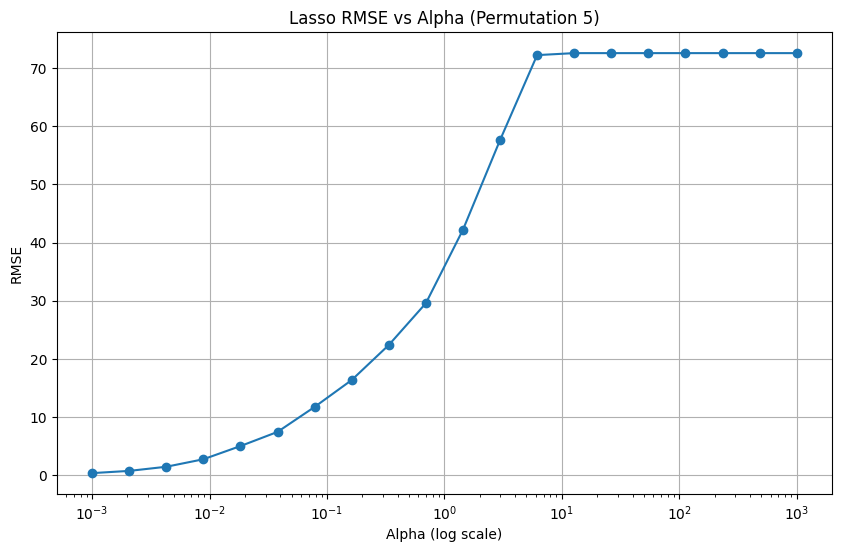

Optimal alpha: 0.3360
CV alpha with 1-std-rule: 0.3360
Final RMSE on 1std test set: 34.2065
Expected Prediction Error 1std (EPE): 1438.3774
Irreducible Error 1std (σₑ²): 507.2469
Bias² 1std: 629.2425
Variance 1std: 301.8880
Final RMSE on test set: 33.5947
Expected Prediction Error (EPE): 1259.9729
Irreducible Error (σₑ²): 401.5534
Bias²: 529.9237
Variance: 328.4958


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the range of alphas for Lasso
alphas = np.logspace(-3, 3, 20)  # Example range of alpha values
K = 5  # Number of cross-validation folds

X_df = pd.DataFrame(X)

# Fill missing values in X with the mean of each column
for col in X_df.columns:
    fill_value = X_df[col].mean()
    X_df[col] = X_df[col].fillna(fill_value)

# Convert back to numpy array
X2 = X_df.values
X2, _, _ = fit_transform_data(X2)
X_new, _, _ = fit_transform_data(X_new)


X_dev, X_final_test, y_dev, y_final_test = train_test_split(X2, y, test_size=0.2, random_state=1312)

# Plot alphas vs RMSE
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Initialize KFold cross-validation
alpha_values = []
rmse_values = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_dev, y_dev)
    y_pred = model.predict(X_dev)
    mse = mean_squared_error(y_dev, y_pred)
    rmse = np.sqrt(mse)
    alpha_values.append(alpha)
    rmse_values.append(rmse)
    # After testing all alphas, plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(alpha_values, rmse_values, marker='o')
plt.xlabel('Alpha (log scale)')
plt.ylabel('RMSE')
plt.title(f'Lasso RMSE vs Alpha (Permutation {perm_idx+1})')
plt.grid(True)
plt.show()


# Store RMSE for each alpha
RMSE = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Perform cross-validation for each alpha
    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=10000)
        # Fill missing values in X_dev with the mean of each column

        scores = cross_val_score(model, X_dev, y_dev, cv=K, scoring='neg_mean_squared_error')
        rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE
        RMSE.append(rmse_scores)

    RMSE = np.array(RMSE)
    meanRMSE = np.mean(RMSE, axis=1)  # Mean RMSE for each alpha
    jOpt = np.argmin(meanRMSE)  # Index of the optimal alpha (smallest RMSE)

# Calculate the standard error for the best alpha
seRMSE = np.std(RMSE, axis=1) / np.sqrt(K)

# Find the largest alpha within one standard error of the optimal alpha
J = np.where(meanRMSE[jOpt] + seRMSE[jOpt] > meanRMSE)[0]
Alpha_CV_1StdRule = alphas[J[-1]]

print(f"Optimal alpha: {alphas[jOpt]:.4f}")
print(f"CV alpha with 1-std-rule: {Alpha_CV_1StdRule:.4f}")

# Train the final model with the selected alpha
final_model = Lasso(alpha=Alpha_CV_1StdRule, max_iter=10000)

# Fit the final model on the entire dev set
final_model.fit(X_dev, y_dev)
# Evaluate the final model on the test set
# Making sure the columns are the same in both datasets
X_final_test = pd.DataFrame(X_final_test)
X_final_test = X_final_test.reindex(columns=columns, fill_value=0)
X_final_test = X_final_test.values
final_rmse2 = np.sqrt(mean_squared_error(y_final_test, final_model.predict(X_final_test)))
print(f"Final RMSE on 1std test set: {final_rmse2:.4f}")

epe2, std2, bias2, var2 = compute_epe_with_small_labeled(final_model, X_dev, y_dev, X_new)


print(f"Expected Prediction Error 1std (EPE): {epe2:.4f}")
print(f"Irreducible Error 1std (σₑ²): {std2:.4f}")
print(f"Bias² 1std: {bias2:.4f}")
print(f"Variance 1std: {var2:.4f}")


# Predict on X_new using the final model
y_new_pred = final_model.predict(X_new)

final_model = Lasso(alpha=np.float64(0.24816289228368263), max_iter=1000) # Use the best model from sorted_models
final_model.fit(X_dev, y_dev)
# Evaluate the final model on the test set
final_rmse = np.sqrt(mean_squared_error(y_final_test, final_model.predict(X_final_test)))
print(f"Final RMSE on test set: {final_rmse:.4f}")

epe, std, bias, var = compute_epe_with_small_labeled(final_model, X_dev, y_dev, X_new)


print(f"Expected Prediction Error (EPE): {epe:.4f}")
print(f"Irreducible Error (σₑ²): {std:.4f}")
print(f"Bias²: {bias:.4f}")
print(f"Variance: {var:.4f}")


# Predict on X_new using the final model
y_new_pred = final_model.predict(X_new)
# Save the predicted values to a CSV file
np.savetxt('predictions_s215160_s242966.csv', y_new_pred, delimiter=',', fmt='%f')

In [17]:
# Expected RMSE
rmse_hat = np.sqrt(epe)

rmse_hat2 = np.sqrt(epe2)
print(f"Expected RMSE (using EPE): {rmse_hat2:.4f}")

print(f"Expected RMSE: {rmse_hat:.4f}")

# Save the predicted values to a CSV file
np.savetxt('estimatedRMSE_s215160_s242966.csv', [rmse_hat])

Expected RMSE (using EPE): 37.9259
Expected RMSE: 35.4961
